# Step 1: Classify A, B, C

## 0. Imports & Global Setting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets

from PIL import Image
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
SEED = 1220
BATCH_SIZE = 64
NUM_CLASSES = 3
EPOCHS = 30
IMAGE_SIZE = 224
LEARNING_RATE = 0.001
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "../data/damage_classification"
TEST_DIR = "../data/test"
CSV_FILE = "../data/submission.csv"
FILE_EXTENSIONS = (".jpg", ".jpeg", ".png")

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
torch.cuda.empty_cache()

In [5]:
print(f"Using device: {DEVICE}")
print(f"Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"Using Pytorch version: {torch.__version__}")
print(f"Using CUDA version: {torch.version.cuda}")
print(f"Using cuDNN version: {torch.backends.cudnn.version()}")

Using device: cuda
Using GPU: NVIDIA GeForce RTX 4070
Using Pytorch version: 2.7.0+cu128
Using CUDA version: 12.8
Using cuDNN version: 90701


## 1. Dataset / DataLoader

In [6]:
transform_train = T.Compose(
    [
        T.Resize(int(IMAGE_SIZE * 1.15)),
        T.RandomCrop(IMAGE_SIZE, padding=int(IMAGE_SIZE * 0.15)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        T.RandomRotation(15),
        T.ToTensor(),
        T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=IMAGENET_MEAN),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
def load_dataset(data_dir, batch_size, split_ratio=0.8):
    dataset = datasets.ImageFolder(data_dir, transform=transform_train)
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [8]:
trainloader, valloader = load_dataset(DATA_DIR, BATCH_SIZE)

## 2. Define Model

In [9]:
from torchvision.models import efficientnet_v2_s


class EfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetV2, self).__init__()
        self.model = efficientnet_v2_s(weights="DEFAULT")
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)


model = EfficientNetV2(NUM_CLASSES).to(DEVICE)

## 3. Train & Validate

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss

        elif val_loss > self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

        else:
            self.best_score = val_loss
            self.counter = 0
            torch.save(model.state_dict(), "../output/damage_classification/models/best_model.pth")
            if self.verbose:
                print(f"✅ Model saved with loss: {val_loss:.4f}")

        return self.early_stop

In [11]:
def train(model, trainloader, valloader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valloader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        print("-" * 60)

        if early_stopping(val_loss, model):
            print("Early stopping")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    class_correct = [0] * NUM_CLASSES
    class_total = [0] * NUM_CLASSES
    cm = torch.zeros(NUM_CLASSES, NUM_CLASSES, dtype=torch.int32)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            for i in range(labels.size(0)):
                label = labels[i]
                pred = predicted[i]
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
                cm[label, pred] += 1

    accuracy = correct / total
    return accuracy, class_correct, class_total, cm

In [13]:
print("Training the model...")
train_losses, val_losses, train_accuracies, val_accuracies = train(model, trainloader, valloader, EPOCHS)

Training the model...


Epoch 1/30: 100%|██████████| 6/6 [00:05<00:00,  1.04batch/s]


Train Loss: 0.8633, Train Acc: 0.5900%
Validation Loss: 1.4990, Val Acc: 0.4066%
------------------------------------------------------------


Epoch 2/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.6659, Train Acc: 0.7424%
Validation Loss: 3.0323, Val Acc: 0.3516%
------------------------------------------------------------


Epoch 3/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.6376, Train Acc: 0.7285%
Validation Loss: 1.5183, Val Acc: 0.5385%
------------------------------------------------------------


Epoch 4/30: 100%|██████████| 6/6 [-1:59:59<00:00, -4.48batch/s]


Train Loss: 0.5387, Train Acc: 0.7839%
Validation Loss: 0.9203, Val Acc: 0.6923%
------------------------------------------------------------
✅ Model saved with loss: 0.9203


Epoch 5/30: 100%|██████████| 6/6 [00:11<00:00,  1.99s/batch]


Train Loss: 0.5772, Train Acc: 0.7895%
Validation Loss: 0.9053, Val Acc: 0.6593%
------------------------------------------------------------
✅ Model saved with loss: 0.9053


Epoch 6/30: 100%|██████████| 6/6 [00:05<00:00,  1.13batch/s]


Train Loss: 0.5095, Train Acc: 0.7950%
Validation Loss: 0.8269, Val Acc: 0.7143%
------------------------------------------------------------
✅ Model saved with loss: 0.8269


Epoch 7/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.4382, Train Acc: 0.8310%
Validation Loss: 0.6669, Val Acc: 0.7143%
------------------------------------------------------------
✅ Model saved with loss: 0.6669


Epoch 8/30: 100%|██████████| 6/6 [00:05<00:00,  1.11batch/s]


Train Loss: 0.5203, Train Acc: 0.7867%
Validation Loss: 0.7909, Val Acc: 0.6923%
------------------------------------------------------------


Epoch 9/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.4692, Train Acc: 0.8255%
Validation Loss: 0.7694, Val Acc: 0.7363%
------------------------------------------------------------


Epoch 10/30: 100%|██████████| 6/6 [00:05<00:00,  1.15batch/s]


Train Loss: 0.4020, Train Acc: 0.8172%
Validation Loss: 0.6812, Val Acc: 0.7363%
------------------------------------------------------------


Epoch 11/30: 100%|██████████| 6/6 [00:05<00:00,  1.13batch/s]


Train Loss: 0.3556, Train Acc: 0.8560%
Validation Loss: 0.7197, Val Acc: 0.7363%
------------------------------------------------------------


Epoch 12/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.3785, Train Acc: 0.8476%
Validation Loss: 0.5011, Val Acc: 0.8132%
------------------------------------------------------------
✅ Model saved with loss: 0.5011


Epoch 13/30: 100%|██████████| 6/6 [00:05<00:00,  1.13batch/s]


Train Loss: 0.3683, Train Acc: 0.8670%
Validation Loss: 0.6365, Val Acc: 0.7473%
------------------------------------------------------------


Epoch 14/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.2731, Train Acc: 0.9086%
Validation Loss: 0.6101, Val Acc: 0.8022%
------------------------------------------------------------


Epoch 15/30: 100%|██████████| 6/6 [-1:59:59<00:00, -4.42batch/s]


Train Loss: 0.3157, Train Acc: 0.9003%
Validation Loss: 0.5481, Val Acc: 0.8132%
------------------------------------------------------------


Epoch 16/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.3434, Train Acc: 0.8615%
Validation Loss: 0.7070, Val Acc: 0.7692%
------------------------------------------------------------


Epoch 17/30: 100%|██████████| 6/6 [00:05<00:00,  1.14batch/s]


Train Loss: 0.2456, Train Acc: 0.9197%
Validation Loss: 0.4593, Val Acc: 0.8132%
------------------------------------------------------------
✅ Model saved with loss: 0.4593


Epoch 18/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.2372, Train Acc: 0.9114%
Validation Loss: 0.5119, Val Acc: 0.8022%
------------------------------------------------------------


Epoch 19/30: 100%|██████████| 6/6 [00:05<00:00,  1.16batch/s]


Train Loss: 0.2211, Train Acc: 0.9141%
Validation Loss: 0.4937, Val Acc: 0.8571%
------------------------------------------------------------


Epoch 20/30: 100%|██████████| 6/6 [00:05<00:00,  1.15batch/s]


Train Loss: 0.1999, Train Acc: 0.9335%
Validation Loss: 0.7706, Val Acc: 0.7692%
------------------------------------------------------------


Epoch 21/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.2123, Train Acc: 0.9114%
Validation Loss: 0.6268, Val Acc: 0.7802%
------------------------------------------------------------


Epoch 22/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.2312, Train Acc: 0.9114%
Validation Loss: 0.6359, Val Acc: 0.8022%
------------------------------------------------------------


Epoch 23/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.1560, Train Acc: 0.9474%
Validation Loss: 0.7725, Val Acc: 0.7363%
------------------------------------------------------------


Epoch 24/30: 100%|██████████| 6/6 [00:05<00:00,  1.12batch/s]


Train Loss: 0.1804, Train Acc: 0.9252%
Validation Loss: 0.7277, Val Acc: 0.7692%
------------------------------------------------------------


Epoch 25/30: 100%|██████████| 6/6 [00:05<00:00,  1.13batch/s]


Train Loss: 0.1709, Train Acc: 0.9391%
Validation Loss: 0.6525, Val Acc: 0.7582%
------------------------------------------------------------


Epoch 26/30: 100%|██████████| 6/6 [-1:59:59<00:00, -4.33batch/s]


Train Loss: 0.2242, Train Acc: 0.9169%
Validation Loss: 0.5145, Val Acc: 0.8242%
------------------------------------------------------------


Epoch 27/30: 100%|██████████| 6/6 [00:05<00:00,  1.11batch/s]


Train Loss: 0.1868, Train Acc: 0.9335%
Validation Loss: 0.5075, Val Acc: 0.8242%
------------------------------------------------------------
Early stopping triggered.
Early stopping


In [14]:
print("Evaluating the model...")
val_accuracy, val_class_correct, val_class_total, val_cm = evaluate(model, valloader)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Evaluating the model...
Validation Accuracy: 0.8242


In [15]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 4. Evaluation & Visualization

In [16]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig('../output/damage_classification/images/training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [17]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    classes = ['A', 'B', 'C']
    num_classes = len(classes)

    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []

    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')

    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('../output/damage_classification/images/per_class_accuracy.png')
    plt.show()

    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone().float()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(
                j,
                i,
                f'{normalized_confusion_matrix[i, j]:.2f}',
                horizontalalignment="center",
                color="white" if normalized_confusion_matrix[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../output/damage_classification/images/confusion_matrix.png')
    plt.show()

    return

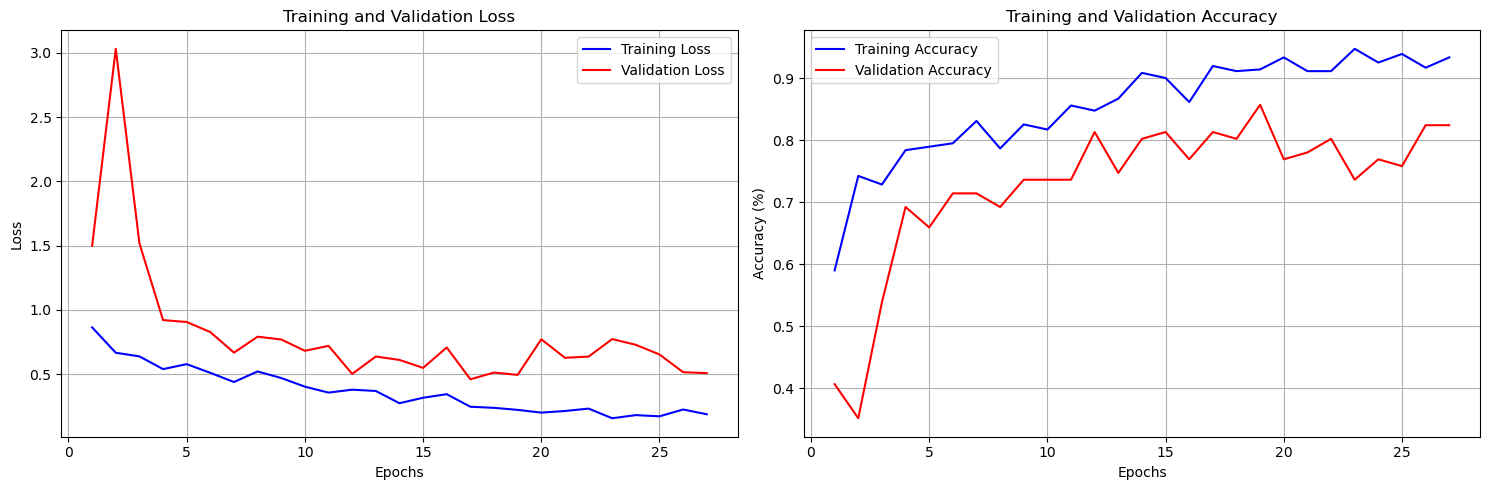

Training metrics plot saved as 'training_metrics.png'

Per-class Accuracy:
--------------------------------------------------
A: 83.33% (25/30)
B: 78.38% (29/37)
C: 87.50% (21/24)


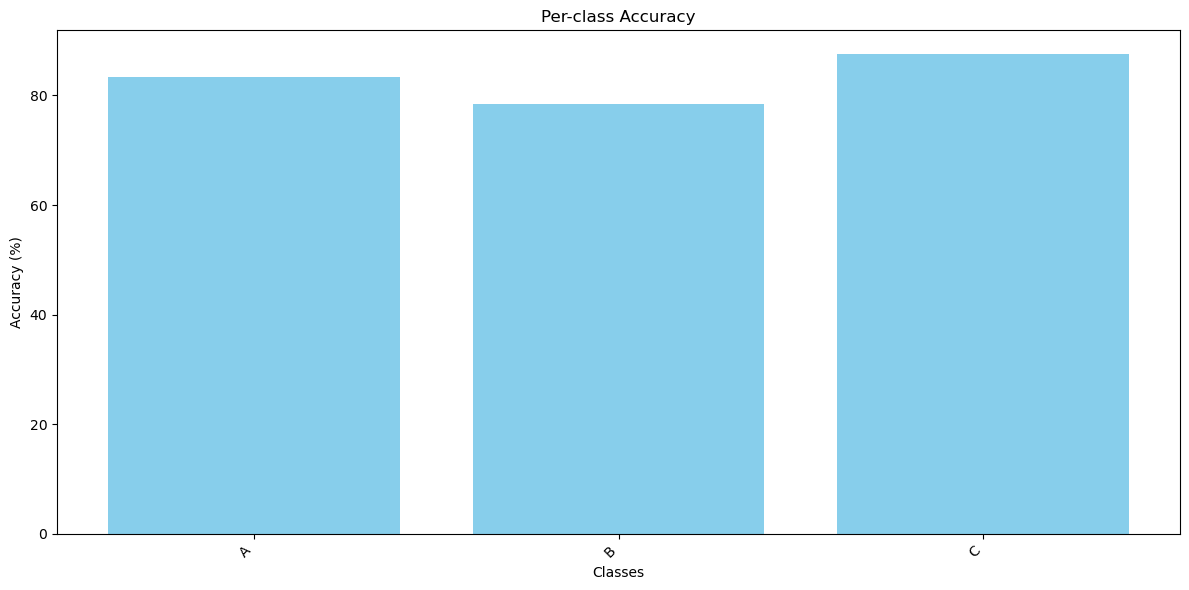

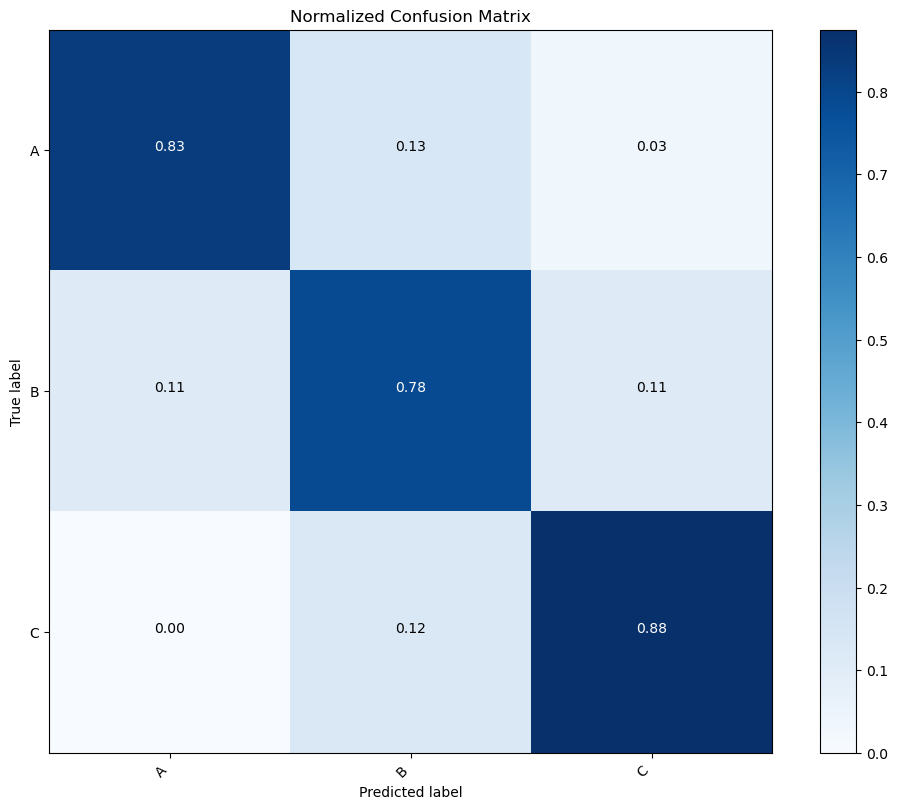

In [18]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)
plot_evaluation_metrics(val_class_correct, val_class_total, val_cm)

## 5. Prediction & Submission

In [19]:
df = pd.read_csv(CSV_FILE)
print(f"Loaded CSV file with {len(df)} entries.")

classes = ['A', 'B', 'C']
columns = df.columns.tolist()
first_col = columns[0]
second_col = columns[1]
df[second_col] = df[second_col].astype('object')

model.load_state_dict(torch.load("../output/damage_classification/models/best_model.pth"))
model.to(DEVICE)
model.eval()

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing test images"):
    image_path = f"{TEST_DIR}/{int(row[first_col])}{FILE_EXTENSIONS[0]}"
    image = Image.open(image_path).convert("RGB")
    image = transform_train(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        df.at[idx, second_col] = classes[predicted.item()]

df.to_csv("../output/damage_classification/submission.csv", index=False)
print("Submission file saved as 'submission.csv'")

Loaded CSV file with 50 entries.


Processing test images: 100%|██████████| 50/50 [-1:59:55<00:00, -9.59it/s]

Submission file saved as 'submission.csv'
